### Convolutional Neural Network 

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
plt.style.use('seaborn-white')
import warnings 
warnings.filterwarnings('ignore','DeprecatedWarnings')

In [2]:
! which python

/Users/rohan/opt/anaconda3/bin/python


In [3]:
! pip install tensorflow

In [4]:
! pip install torch
! pip install torchvision

In [5]:
torch.__version__

'1.7.1'

### Loading Datasets 

In [6]:
# MNIST Is considered to be the Hello World of CNN's and Deep Learning in General, so it is 
# generally provided from as the inbuild go-to project for beginners 
transforms = transforms.ToTensor()
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transforms)
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transforms)

In [7]:
train_data 

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [8]:
test_data 

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

### Data Loader Object

In [9]:
# Pytorch's convention to create dataloader objects, to be used in the models train cycle 
batch_s = 10
train_loader = DataLoader(train_data,batch_size=batch_s,shuffle=True)
test_loader = DataLoader(test_data,batch_size=batch_s,shuffle=False) 

### What is the Data about? 

In [10]:
# pipeline obj=1/
desc = '''
The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.
'''
print(desc)


The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.



In [11]:
(x_train, y_train) = train_data[0] # one sample

In [12]:
y_train # label

5

Text(0.5, 1.0, 'label 5')

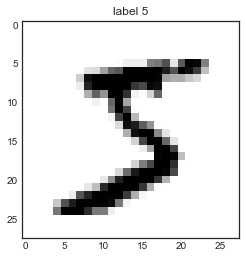

In [13]:
plt.imshow(x_train[0],cmap='binary')
plt.title('label {}'.format(y_train))

### Convolutional Neural Network Class

### Buidling Model 

In [14]:
class convolutional(nn.Module):
    
    def __init__(self,in_channel=1,output=10): 
        super().__init__() # inheriting nn.Module
        # defining Layer Functions 
        # input dimension = (b,28,28,1)
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=6, kernel_size=(3,3), stride=1 )
        # (b,26,26,6)
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)) # f=2, s=2 
        #  dimension (b,12,12,6)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=(3,3),stride=1)
        # dimension (b,10,10,16)
        # we apply one more pool after this dimension so (b,5,5,16)
        self.fc1 = nn.Linear(5*5*16,120)
        self.fc2 = nn.Linear(120, 64)
        self.fc3 = nn.Linear(in_features=64,out_features=output)

    def forward(self,X):
        # Construction of the Architecture 
        X = F.relu(self.conv1(X))
        X = self.pool(X)
        X = F.relu(self.conv2(X))
        X = self.pool(X)
        X = X.view(-1, 5*5*16) # Flatten
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)
    
    
        
        


In [15]:
net = convolutional()

In [16]:
net

convolutional(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [17]:
print('Total Learnable Params :')
params = [p.numel() for p in net.parameters() if p.requires_grad]
for item in params:
    print(f'{item:>10}')
print(f'___________\n{sum(params):>10}')

Total Learnable Params :
        54
         6
       864
        16
     48000
       120
      7680
        64
       640
        10
___________
     57454


In [18]:
# defining the loss function and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)

In [19]:
# The TRAIN CYCLE 
import time 
start = time.perf_counter()
# trackers, for post evaluation
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []
accuracy = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = net(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        _, predicted = y_pred.max(1)
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
            accuracy.append(trn_corr.item()*100/(10*b))
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = net(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
    
elapsed = (time.perf_counter() - start)/60
print('ELAPSED {:.2f}'.format(elapsed))
        


epoch:  0  batch:  600 [  6000/60000]  loss: 0.11527220  accuracy:  75.417%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.02267704  accuracy:  84.042%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.03113074  accuracy:  87.533%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.06842645  accuracy:  89.537%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.01015474  accuracy:  90.797%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.03443994  accuracy:  91.736%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.01772033  accuracy:  92.517%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.02657677  accuracy:  92.994%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.01951578  accuracy:  93.450%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.00621798  accuracy:  93.820%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.43192950  accuracy:  97.633%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.14040636  accuracy:  97.700%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.00198762  accuracy:  97.733%
epoch:  1  b

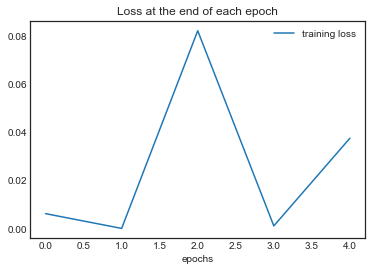

In [20]:
plt.plot(train_losses, label='training loss')
plt.title('Loss at the end of each epoch')
plt.xlabel('epochs')
plt.legend();

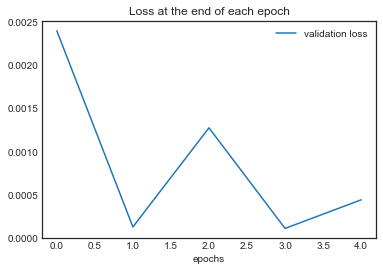

In [21]:
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.xlabel('epochs')
plt.legend();

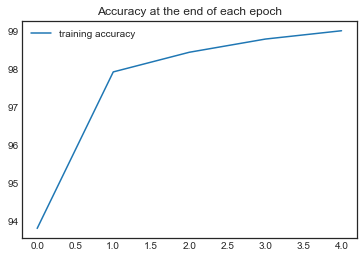

In [22]:
plt.plot([t/600 for t in train_correct], label='training accuracy')

plt.title('Accuracy at the end of each epoch')
plt.legend();

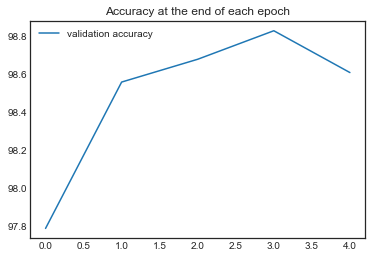

In [23]:
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

### Overall Evaluation

In [24]:
test_load = DataLoader(test_data,batch_size=10000, shuffle=False)

In [25]:
with torch.no_grad():
    correct = 0
    for x_test, y_test in test_load:
        y_val = net(x_test)
        _, predicted = y_val.max(1)
        correct += (predicted == y_test).sum()
        
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9861/10000 =  98.610%


In [26]:
predicted

tensor([7, 2, 1,  ..., 4, 5, 6])

In [27]:
# Classification Report
class_report = classification_report(y_test,predicted)
print(class_report)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.98      0.99      0.98      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.99      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [28]:
# Missed Pictures and their indexes
misses = np.array([])

for i in range(len(predicted.view(-1))):
    
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
    
misses

array([ 115,  326,  340,  412,  449,  582,  625,  691,  740,  844,  846,
        900,  947, 1014, 1039, 1112, 1182, 1226, 1242, 1247, 1292, 1299,
       1328, 1393, 1459, 1522, 1530, 1621, 1709, 1737, 1790, 1878, 1901,
       1955, 1987, 2018, 2024, 2035, 2070, 2109, 2130, 2135, 2185, 2188,
       2195, 2258, 2293, 2300, 2447, 2488, 2597, 2654, 2770, 2771, 2894,
       2921, 2927, 2953, 3023, 3073, 3225, 3288, 3441, 3520, 3597, 3626,
       3727, 3762, 3767, 3806, 3808, 3850, 3871, 3906, 3926, 3968, 4007,
       4078, 4123, 4176, 4211, 4256, 4306, 4350, 4360, 4369, 4497, 4507,
       4536, 4571, 4639, 4731, 4761, 4837, 4838, 4860, 4880, 4911, 5246,
       5331, 5642, 5734, 5870, 5937, 5981, 5997, 6101, 6532, 6560, 6571,
       6597, 6625, 6651, 6662, 6783, 6954, 7432, 7847, 7856, 7899, 7928,
       8094, 8128, 8316, 8325, 8382, 8408, 8520, 9009, 9015, 9019, 9024,
       9540, 9692, 9729, 9770, 9781, 9792, 9850])

### Single Image Test

Text(0.5, 1.0, 'Label 3')

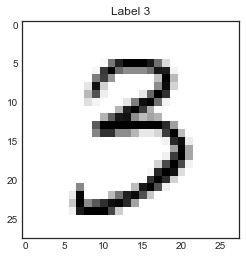

In [29]:
index = 2020
plt.figure(figsize=(4,4))
plt.imshow(x_test[index].reshape(28,28),cmap='binary')
plt.title('Label {}'.format(y_test[2020]))

In [30]:
net.eval()
with torch.no_grad():
    yhat = net(x_test[index][0].view(1,1,28,28))
    print('Prediction ~ {}'.format(yhat.argmax()))
    print('Reality - {}'.format(y_test[index]))

Prediction ~ 3
Reality - 3


### Miscellaneous

In [31]:
# PipeLine Script Data  

In [32]:
note = '''Considering the Visualisations concerning train-cycle and test-cycle, after the 3rd epoch the training error starts increasing ever-so slightly which determines that after 3rd epoch with this network architecture the model overfits the data. This is evident in the difference between train-accuracy and test-accuracy. But this problem is not prominent to work on reducing that difference, if we are supposed to reduce that error we can try using dropout layers and early-stopping techniques'''


In [33]:
note = note.strip()

In [34]:
np.round(np.mean(accuracy),2)

96.66

In [101]:
desc = desc.strip()
project_name = 'MNIST'
framework = 'Pytorch'
prediction_type = 'Multi-Class Classification - 10 Classes'
network_type = 'Convolutional Neural Network'
architecture = str(net)
layers = 6
hidden_units = None 
activations = "['relu','softmax']"
epochs = 5
metrics = 'Accuracy'
loss = 'Categorical Cross-Entropy'
optimiser = 'Adam'
learning_rate = 'Alpha = 0.001'
batch_size = 16
train_accuracy = np.round(np.mean(accuracy),2)
test_accuracy = 98.720
classification_report = class_report
elapsed = '2.48 Min'
summary = note
ipynb = './Projects/MNIST/Pytorch/MNIST-Pytorch.pdf'
plots = './Projects/MNIST/Pytorch/Plots'


In [102]:
param = dict()
var_dict = {}
var = ['desc','project_name', 'framework','prediction_type','network_type',
       'architecture','layers','hidden_units','activations','epochs',
       'metrics','loss','optimiser','learning_rate','batch_size','train_accuracy','test_accuracy','classification_report','elapsed','summary'
       ,'ipynb','plots']

for i in var:
    var_dict[i] = input(f'Enter Dtype for {i}: ')



Enter Dtype for desc: string
Enter Dtype for project_name: string
Enter Dtype for framework: string
Enter Dtype for prediction_type: string
Enter Dtype for network_type: string
Enter Dtype for architecture: string
Enter Dtype for layers: int
Enter Dtype for hidden_units: int
Enter Dtype for activations: string(list)
Enter Dtype for epochs: int
Enter Dtype for metrics: string(list)
Enter Dtype for loss: string
Enter Dtype for optimiser: string
Enter Dtype for learning_rate: float
Enter Dtype for batch_size: int/string
Enter Dtype for train_accuracy: float%
Enter Dtype for test_accuracy: float%
Enter Dtype for classification_report: string
Enter Dtype for elapsed: float
Enter Dtype for summary: string
Enter Dtype for ipynb: path
Enter Dtype for plots: path


In [103]:
len(var_dict.keys())

22

In [104]:
import pickle
with open('../../var-dict.txt','wb') as f:
    pickle.dump(var_dict,f)

In [105]:
! ls ../../

MNIST                   pipeline.py             var-dict.txt
PipeLine Testing .ipynb sample_data.py
__init__.py             test.pt


In [106]:
for val in var:
    try:
        param[val] = eval(val)
    except:
        param[val] = val

In [107]:
param

{'desc': 'The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.',
 'project_name': 'MNIST',
 'framework': 'Pytorch',
 'prediction_type': 'Multi-Class Classification - 10 Classes',
 'network_type': 'Convolutional Neural Network',
 'architecture': 'convolutional(\n  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))\n  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)\n  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))\n  (fc1): Linear(in_features=400, out_features=120, bias=True)\n  (fc2): Linear(in_features=120, out_features=64, bias=True)\n  (fc3): Linear(in_features=64, out_features=10, bias=True)\n)',
 'layers': 6,
 'hidden_units': None,
 'activations': "['relu','softmax']",
 'epochs': 5,
 'metrics': 'Accuracy',
 'lo

In [109]:
param['optimiser']

'Adam'

In [110]:
import pickle
file = open("artefacts.txt", "wb") 
  
dictionary = param 
pickle.dump(dictionary, file) 
file.close() 


In [83]:
jsondata

{'desc': 'The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.',
 'project_name': 'MNIST',
 'framework': 'Pytorch',
 'prediction_type': 'Classification',
 'network_type': 'Convolutional Neural Network',
 'architecture': 'convolutional(\n  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))\n  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)\n  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))\n  (fc1): Linear(in_features=400, out_features=120, bias=True)\n  (fc2): Linear(in_features=120, out_features=64, bias=True)\n  (fc3): Linear(in_features=64, out_features=10, bias=True)\n)',
 'layers': 6,
 'hidden_units': None,
 'activations': "['relu','softmax']",
 'epochs': 5,
 'metrics': 'Accuracy',
 'loss': 'Categorical Cross-E

In [47]:
import pandas as pd
pd.DataFrame(pd.Series(param)).T

,desc,project_name,framework,prediction_type,network_type,architecture,layers,hidden_units,activations,epochs,metrics,loss,train_accuracy,test_accuracy,classification_report,elapsed,summary,ipynb,plots
0,"The MNIST database of handwritten digits, avai...",MNIST,Pytorch,Classification,Convolutional Neural Network,"convolutional(\n (conv1): Conv2d(1, 6, kernel...",6,None,"['relu','softmax']",5,Accuracy,tensor(0.0004),96.66,98.72,precision recall f1-score ...,2.48 Min,Considering the Visualisations concerning trai...,./Projects/MNIST/Pytorch/MNIST-Pytorch.pdf,./Projects/MNIST/Pytorch/Plots


In [69]:
list(param.keys())[3:-1]

['prediction_type',
 'network_type',
 'architecture',
 'layers',
 'hidden_units',
 'activations',
 'epochs',
 'metrics',
 'loss',
 'train_accuracy',
 'test_accuracy',
 'classification_report',
 'elapsed',
 'summary',
 'ipynb']

In [66]:
list(param.values())[0]

'The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.'

In [111]:
param.keys()

dict_keys(['desc', 'project_name', 'framework', 'prediction_type', 'network_type', 'architecture', 'layers', 'hidden_units', 'activations', 'epochs', 'metrics', 'loss', 'optimiser', 'learning_rate', 'batch_size', 'train_accuracy', 'test_accuracy', 'classification_report', 'elapsed', 'summary', 'ipynb', 'plots'])

In [ ]:
# import os 
# string = '/Users/Shared/Relocated/Security/Code/Deep_Learning/DeepLearning-Conjunction/Git/Dev/Projects/MNIST/Pytorch'.split('/')
# os.path.join('./',*string[-3:])

In [112]:
import pickle
prompt_list = ['Prediction Type : ','Network Type : ', 'Network Architecture : ', 'Number of Layers : ', 
'Number of Hidden Units :', 'Activations Used : ', 'Number of Epochs : ', 'Metrics: ','Loss Function: ',
'Optimizer : ','Learning Rate : ','Batch Size : ','Train Accuracy:','Test Accuracy : ','Classification Report: ', 'Elapsed Time for Training : '] 
f_pl = open('../../../prompt-list.txt','wb')

pickle.dump(prompt_list, f_pl)
f_pl.close()


In [ ]:
# prompt_list

In [52]:


with open('../../../prompt-list.txt', 'rb') as f:
    
    data = f.read() 
        

d = pickle.loads(data) 

In [53]:
d

['Prediction Type : ',
 'Network Type : ',
 'Network Architecture : ',
 'Number of Layers : ',
 'Number of Hidden Units :',
 'Activations Used : ',
 'Number of Epochs : ',
 'Metrics: ',
 'Loss Function: ',
 'Train and Test Accuracy : ',
 'Elapsed Time for Training : ']

In [39]:
import datetime
datetime.datetime.now()

datetime.datetime(2021, 1, 30, 2, 19, 55, 508952)